# DATASET1: HANDWRITING RECOGNITION

## Exploratory Data Analysis

In [49]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

train_size = 12000 # %80
valid_size= 3000 # %20

char_list = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' " #"!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

train = pd.read_csv('handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('handwriting-recognition/written_name_validation_v2.csv')

train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [50]:
train.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_00001.jpg,THOMAS
freq,1,1825


In [51]:
train.shape

(330961, 2)

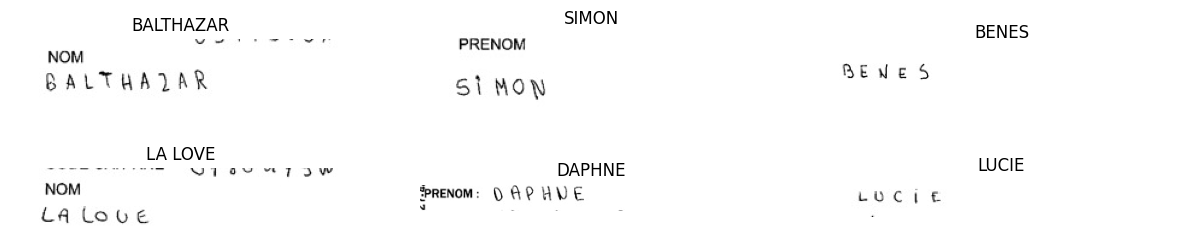

In [52]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [53]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


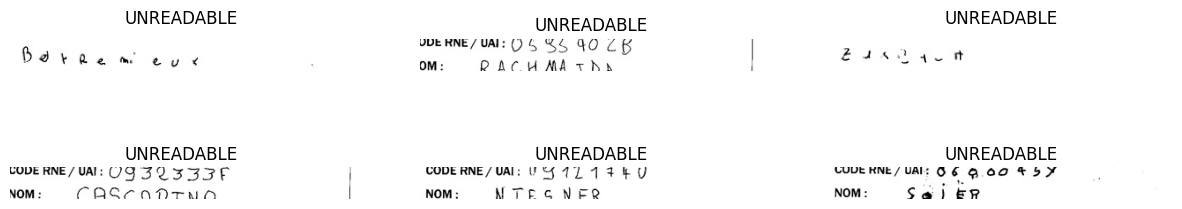

In [54]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

In [55]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255
    
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(char_list.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    if isinstance(num, int):  # if num is a single integer
        return char_list[num]
    else:  # if num is an iterable
        ret = ""
        for ch in num:
            if ch == 0:  # CTC Blank
                break
            else:
                ret += char_list[ch-1]
        return ret

In [56]:
train_x = []
for i in range(train_size):
    img_dir = 'handwriting-recognition/train_v2/train/' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)
    
valid_x = []
for i in range(valid_size):
    img_dir = 'handwriting-recognition/validation_v2/validation/' + valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)
    
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [57]:
max_str_len = 24 # max length of input labels
num_of_characters = len(char_list) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [58]:
train_x_flattened = train_x.reshape(train_x.shape[0], -1)
valid_x_flattened = valid_x.reshape(valid_x.shape[0], -1)

from sklearn.preprocessing import LabelEncoder

# Convert labels to strings
train_y_str = [''.join(map(str, label)) for label in train_y]

# Transform labels into integers
le = LabelEncoder()
train_y_int = le.fit_transform(train_y_str)

valid_y_str = [''.join(map(str, label)) for label in valid_y]

le = LabelEncoder()
valid_y_int = le.fit_transform(valid_y_str)

## CNN + RNN

In [59]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

In [60]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [61]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [62]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=2, batch_size=128)

Epoch 1/2
94/94 ━━━━━━━━━━━━━━━━━━━━ 88s 910ms/step - loss: 54.2564 - val_loss: 21.3704
Epoch 2/2
94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 924ms/step - loss: 20.7308 - val_loss: 20.7798


In [66]:
preds = model.predict(valid_x)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


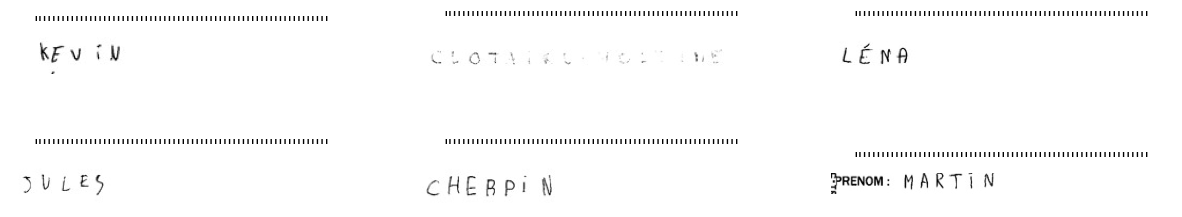

In [68]:
test = pd.read_csv('handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
model.fit(train_x_flattened, train_y)

RandomForestClassifier(max_depth=10, random_state=0)

In [6]:
y_pred = model.predict(valid_x_flattened)

prediction = []
for i in range(len(y_pred)):
    prediction.append(num_to_label(np.round(y_pred[i]).astype(int)))

y_true = valid.loc[0:len(y_pred), 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(len(y_pred)):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(y_pred)))

Correct characters predicted : 14.71%
Correct words predicted      : 0.00%


## KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x_flattened, train_y_int)
knn_pred = knn.predict(valid_x_flattened)
print("kNN Accuracy:", metrics.accuracy_score(valid_y_int, knn_pred))

kNN Accuracy: 0.0


## MLP

In [28]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
mlp.fit(train_x_flattened, train_y_int)
mlp_pred = mlp.predict(valid_x_flattened)
print("MLP Accuracy:", metrics.accuracy_score(valid_y_int, mlp_pred))

Iteration 1, loss = 9.27388069
Iteration 2, loss = 9.21676998
Iteration 3, loss = 9.15425791
Iteration 4, loss = 9.09406038
Iteration 5, loss = 9.03703172
Iteration 6, loss = 8.98407823
Iteration 7, loss = 8.93610496
Iteration 8, loss = 8.89331561
Iteration 9, loss = 8.85585541
Iteration 10, loss = 8.82334134


/home/shc/miniconda3/envs/tfenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy: 0.0


## SVM

In [ ]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC()
clf.fit(train_x_flattened, train_y_int)
svm_pred = clf.predict(valid_x_flattened)
print("SVM Accuracy:", metrics.accuracy_score(valid_y, svm_pred))